In [1]:
# Import the standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

____
## Basic Facts About The Data

The data set is the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013). The set contains a mixture of text features and numerical features. The numerical columns correspond to some aspect of a rating of the review in that row. In particular

* The **stars** column is the number of stars (1 through 5) assigned by the reviewer to the business.
* The **cool** column is the number of "cool" votes this review received from other Yelp users. By default, all reviews start with **cool**=0, and increments by one everytime another user deems the review "cool". There is no upper bound on the number of "cool" votes a review can receieve.
* The **useful** and **funny** columns also correspond to evaluations of the row's review. They both also start at 0 and are incremented in the same way. They are both unbounded above.
* The **date** column is the date of the review posting.

The text columns are:
* **business_id**: An ID used by Yelp to identify the business
* **review_id**: An ID used by Yelp to identify the review
* **user_id**: An ID used by Yelp to identify the user.
* **text**: The actual content of the review.
* **type**: A vestigial tag in the data set; all rows have the value 'review'.

In [2]:
yelp = pd.read_csv('yelp.csv')

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


We may find it useful to create our own feature corresponding to the length of the review. A basic way of doing that is to keep track of the number of characters used.

In [3]:
yelp['text length']=yelp['text'].apply(len)

____
## Exploratory Data Analysis

Let's get a sense of the distribution of review lengths. We'll do this by looking at our **text length** column, grouped according to the value of the **start** column.

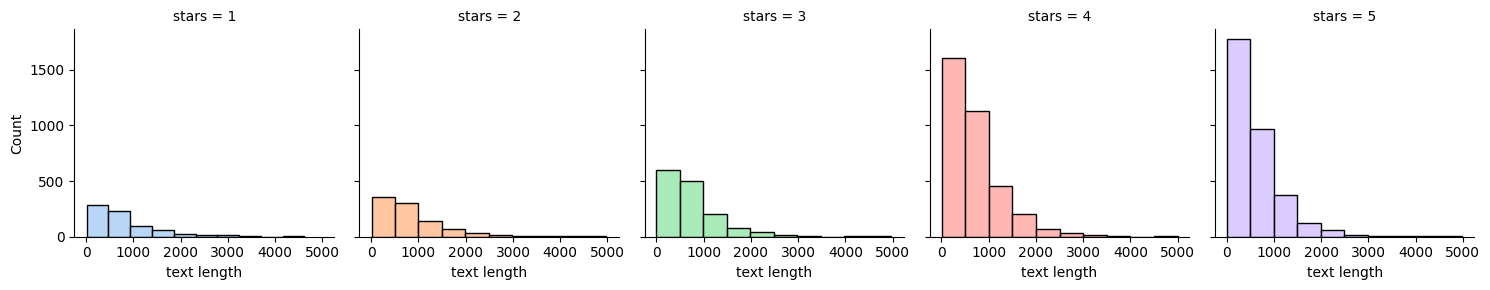

In [12]:
g = sns.FacetGrid(data=yelp, col='stars', hue='stars', palette='pastel')
g.map_dataframe(sns.histplot, x='text length', bins=10)
plt.tight_layout()

An immediate thing we notice is that 4 & 5 star reviews are for more common than the others. We also notice that reviews tend to be shorter no matter what the rating.

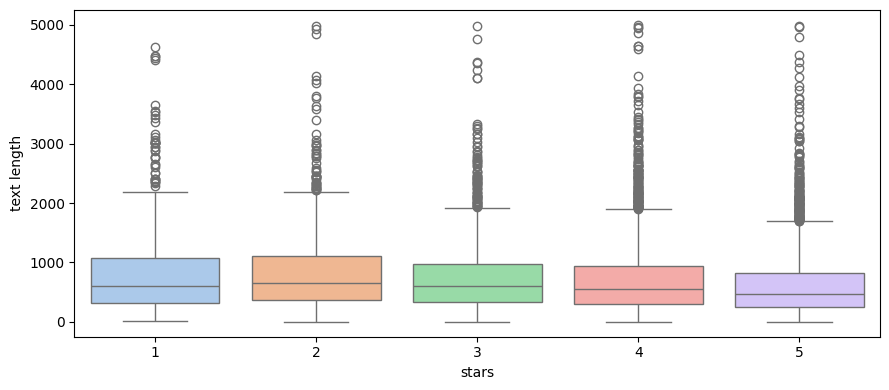

In [16]:
plt.figure(figsize=(9,4))
sns.boxplot(data=yelp, x='stars', y='text length', hue='stars', palette='pastel', legend=False)
plt.tight_layout()

This reaffirms the observation that all reviews tend to be shorter. In fact they all tend to be more or less the same length.

In [20]:
yelp['stars'].value_counts()

stars
4    3526
5    3337
3    1461
2     927
1     749
Name: count, dtype: int64

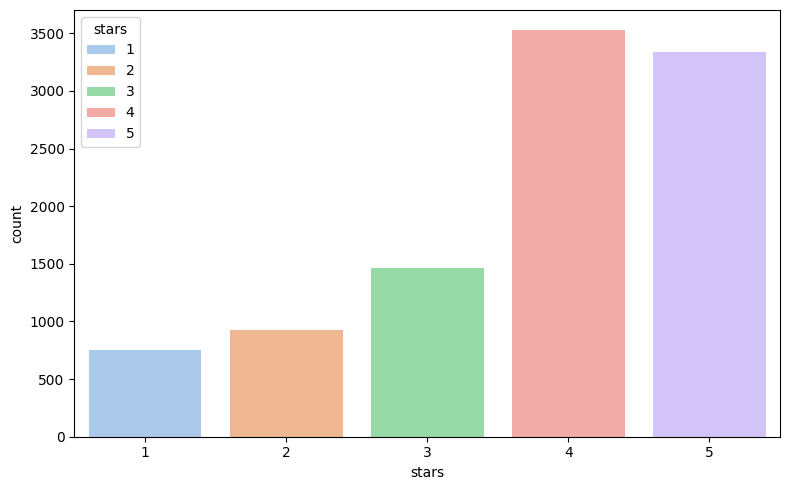

In [19]:
plt.figure(figsize=(8,5))
sns.countplot(data=yelp, x='stars', hue='stars', palette='pastel')
plt.tight_layout()

This clarifies the observation earlier that 4 & 5 star reviews are the most common. It turns out that 4 stars are the most common of all of them, but only by ~200.

To conclude our exploratory analysis, we'll look at the correlations between the numeric features. There are two ways to do this: 
1. By looking at all of the data, including the star values
2. By first finding the mean values of each feature based on star-value

We're interested in how the samples behave when grouped based on their star-values, so we'll go with method 2. Note that the two methods would in fact produce different correlation results.

In [22]:
yelp.groupby('stars').mean(numeric_only=True).corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


Text(0.5, 1.0, 'Method 2')

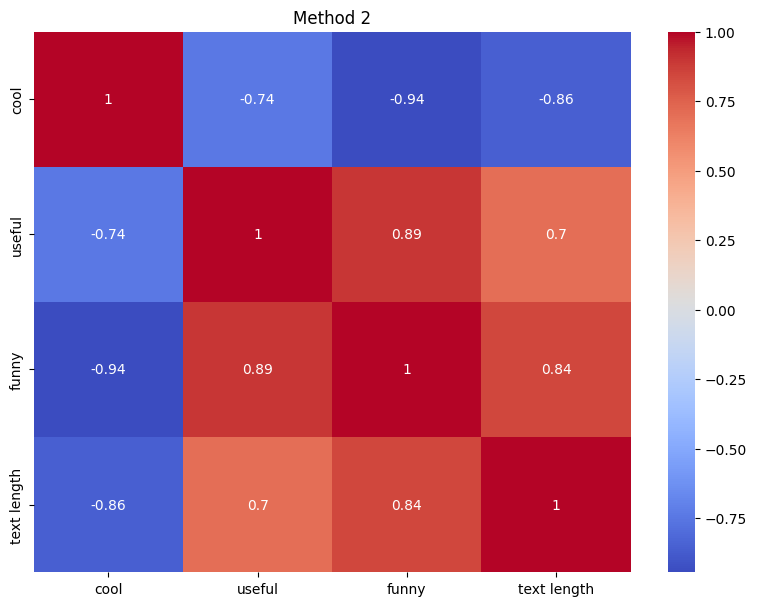

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(data=yelp.groupby('stars').mean(numeric_only=True).corr(), cmap='coolwarm', robust=True, annot=True)
plt.tight_layout()
plt.title('Method 2')

____
## NLP Classification

To start, let's consider a simple classification problem: predict whether a review will be 1 star or 5 stars.

In [4]:
yelp_class = yelp[(yelp['stars']==1) | (yelp['stars']==5)]
X = yelp_class['text']
y = yelp_class['stars']

We need to convert the words in the review to tokens and then count how many time they each appear. For the first pass at classification, we are not going to remove common words or use a custom analyzer.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
bow_transformer = CountVectorizer()

In [22]:
X = bow_transformer.fit_transform(X)

In [13]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Training a Model

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [25]:
nb.fit(X_train, y_train)

MultinomialNB()

____
## Predictions and Evaluations

In [26]:
preds = nb.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

In [27]:

print('Classification Report: \n', classification_report(y_test, preds))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, preds))

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



Confusion Matrix: 
 [[159  69]
 [ 22 976]]


This model does quite well at classifying the reviews. The recall and f1-score for the 1 star reviews is not as good as the 5 star ones because the data set is unbalanced.

____
## Using Text Processing

As a second pass at NLP, we'll take a slightly more sophisticated approach and include feature extraction via TF-IDF.

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
from sklearn.pipeline import Pipeline

In [57]:
pipe = Pipeline([
    ('vectorize', CountVectorizer()),
    ('tfidf transform', TfidfTransformer()),
    ('mb', MultinomialNB())
])

The data needs to be re-split because we wrote over **X** earlier.

In [58]:
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [59]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorize', CountVectorizer()),
                ('tfidf transform', TfidfTransformer()),
                ('mb', MultinomialNB())])

In [60]:
pipe_preds = pipe.predict(X_test)

In [61]:
print('Classification Report (TF-IDF): \n', classification_report(y_test, pipe_preds))
print('\n')
print('Confusion Matrix (TF-IDF): \n', confusion_matrix(y_test, pipe_preds))

Classification Report (TF-IDF): 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



Confusion Matrix (TF-IDF): 
 [[  0 228]
 [  0 998]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Looks like TF-IDF actually made the model worse!

____
## Custom Analyzer

In [9]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

In [7]:
from nltk.corpus import stopwords

In [8]:
#This function is taken from the lecture on NLP
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [76]:
pipe2 = Pipeline([
    ('vect', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('mb', MultinomialNB())
])

In [ ]:
pipe2.fit(X_train, y_train)

In [67]:
pipe2_preds = pipe2.predict(X_test)

In [68]:
print('Classification Report (TF-IDF): \n', classification_report(y_test, pipe_preds))
print('\n')
print('Confusion Matrix (TF-IDF): \n', confusion_matrix(y_test, pipe_preds))

Classification Report (TF-IDF): 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



Confusion Matrix (TF-IDF): 
 [[  0 228]
 [  0 998]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

This still hasn't helped, so maybe we can tune the hyper-parameters of our classifier in order to obtain better results (or at least comparable to the naive approach!).

In [69]:
from sklearn.model_selection import GridSearchCV

In [77]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'mb__alpha': (1e-2, 1e-3)
    }

In [79]:
gs_pipe2 = GridSearchCV(pipe2, parameters, refit=True, verbose=3)

In [ ]:
gs_pipe2.fit(X_train, y_train)
#Verbose output removed for brevity

In [81]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_pipe2.best_params_[param_name]))

mb__alpha: 0.01
tfidf__use_idf: False
vect__ngram_range: (1, 1)


In [82]:
gs_preds = gs_pipe2.predict(X_test)
print('Classification Report (GS): \n', classification_report(y_test, gs_preds))
print('\n')
print('Confusion Matrix (GS): \n', confusion_matrix(y_test, gs_preds))

Classification Report (GS): 
               precision    recall  f1-score   support

           1       0.93      0.55      0.69       228
           5       0.91      0.99      0.95       998

    accuracy                           0.91      1226
   macro avg       0.92      0.77      0.82      1226
weighted avg       0.91      0.91      0.90      1226



Confusion Matrix (GS): 
 [[125 103]
 [ 10 988]]


Notice that the grid search found it was better to <i>not</i> use IDF with this classifier. So, this contains the text processing in the vectorizing layer, but not the IDF. This version of the model performs differently than the first pass approach: assessing which did better would depend on whether we care more about precision or recall for the 1-star category.

____
### Trying A Different Classifier
The Multinomial classifier is meant to work with occurence counts, which is why it did not like the TF-IDF we added in. Since there are only two categories for the outcome to be, we can use the Bernouilli classifier (which will like TF-IDF more).

In [5]:
from sklearn.naive_bayes import BernoulliNB

In [28]:
pipe3 = Pipeline([
    ('vectorize', CountVectorizer(analyzer=text_process)),
    ('tfidf transform', TfidfTransformer()),
    ('catb', BernoulliNB())
])

In [29]:
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [30]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 CountVectorizer(analyzer=<function text_process at 0x141ccf6a0>)),
                ('tfidf transform', TfidfTransformer()),
                ('catb', BernoulliNB())])

In [20]:
bern_preds = pipe3.predict(X_test)
print('Classification Report (Ber): \n', classification_report(y_test, bern_preds))
print('\n')
print('Confusion Matrix (Ber): \n', confusion_matrix(y_test, bern_preds))

Classification Report (Ber): 
               precision    recall  f1-score   support

           1       0.62      0.38      0.47       228
           5       0.87      0.95      0.91       998

    accuracy                           0.84      1226
   macro avg       0.74      0.66      0.69      1226
weighted avg       0.82      0.84      0.83      1226



Confusion Matrix (Ber): 
 [[ 87 141]
 [ 54 944]]


In [32]:
bern_preds = pipe3.predict(X_test)
print('Classification Report (Ber, custom analyzer): \n', classification_report(y_test, bern_preds))
print('\n')
print('Confusion Matrix (Ber, custom analyzer): \n', confusion_matrix(y_test, bern_preds))

Classification Report (Ber, custom analyzer): 
               precision    recall  f1-score   support

           1       0.70      0.25      0.37       228
           5       0.85      0.97      0.91       998

    accuracy                           0.84      1226
   macro avg       0.77      0.61      0.64      1226
weighted avg       0.82      0.84      0.81      1226



Confusion Matrix (Ber, custom analyzer): 
 [[ 57 171]
 [ 25 973]]


The Bernoulli classifier performs worse with our custom text analyzer than without it. Neither case performs as well as the first pass approach above. It is possible that a grid search might help us.

____
## Conclusion

We found that for the task at hand, a straightforward NLP model with no text pre-processing performed (arguably) the best out of all of the models we tried. We should also note that we restricted ourselves to only two of the **star** values. If we were to consider more, we would likely need more data to get good results, and we'd probably have to stick with the Multinomial classifier.